In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#Library untuk tahap Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#Library untuk menggunakan algoritma Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample

In [2]:
df_AllApp_Labeled = pd.read_csv(r"/content/hasil_labelingheyjapan.csv")

In [3]:
# Langkah 1: Cek distribusi label
print("Distribusi awal:")
print(df_AllApp_Labeled['polarity'].value_counts())

# Langkah 2: Pisahkan data berdasarkan label
df_AllApp_Labeled_positive = df_AllApp_Labeled[df_AllApp_Labeled['polarity'] == 'positive']
df_AllApp_Labeled_neutral  = df_AllApp_Labeled[df_AllApp_Labeled['polarity'] == 'neutral']
df_AllApp_Labeled_negative = df_AllApp_Labeled[df_AllApp_Labeled['polarity'] == 'negative']

# Langkah 3: Oversample yang minoritas (neutral dan negative) hingga sama banyak dengan positive
df_AllApp_Labeled_neutral_upsampled = resample(df_AllApp_Labeled_neutral,
                                replace=True,
                                n_samples=len(df_AllApp_Labeled_positive),
                                random_state=42)

df_AllApp_Labeled_negative_upsampled = resample(df_AllApp_Labeled_negative,
                                 replace=True,
                                 n_samples=len(df_AllApp_Labeled_positive),
                                 random_state=42)

# Langkah 4: Gabungkan semua
df_AllApp_Labeled_balanced = pd.concat([df_AllApp_Labeled_positive, df_AllApp_Labeled_neutral_upsampled, df_AllApp_Labeled_negative_upsampled])

# Langkah 5: Shuffle
df_AllApp_Labeled_balanced = df_AllApp_Labeled_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Cek hasil balancing
print("\nDistribusi setelah balancing:")
print(df_AllApp_Labeled_balanced['polarity'].value_counts())

# -----------------------
# 2. Tokenizer & Padding
# -----------------------

MAX_LEN = 200  # atau sesuai panjang rata-rata teks

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_AllApp_Labeled_balanced['text_final_stemmed'])

sequences = tokenizer.texts_to_sequences(df_AllApp_Labeled_balanced['text_final_stemmed'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# -----------------------
# 3. Encode Label
# -----------------------

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_AllApp_Labeled_balanced['polarity'])  # 0, 1, 2

# Ubah ke one-hot encoding
labels_onehot = to_categorical(labels)



Distribusi awal:
polarity
positive    3446
neutral      424
negative       6
Name: count, dtype: int64

Distribusi setelah balancing:
polarity
neutral     3446
positive    3446
negative    3446
Name: count, dtype: int64


In [4]:
# -----------------------
# Train-Test Split
# -----------------------

X_train, X_test, y_train, y_test = train_test_split(
    padded, labels_onehot, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nJumlah data latih: {len(X_train)} | data uji: {len(X_test)}")


Jumlah data latih: 8270 | data uji: 2068


In [5]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=MAX_LEN))  # MAX_LEN dari pipeline tadi
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # jumlah kelas = dimensi one-hot

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Custom callback: Berhenti kalau akurasi training dan val > 93%
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93:
            print("\n🚨 Akurasi training dan validasi >93%! Pelatihan dihentikan.")
            self.model.stop_training = True

# Early stopping: stop jika val_loss tidak membaik dalam 5 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,  # Optional, agar bobot terbaik diambil
    verbose=1
)

# Simpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint(
    'best_model_lstm.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


# Gabungkan semua callbacks
callbacks = [early_stop, checkpoint, myCallback()]

In [7]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.7316 - loss: 0.6073
Epoch 1: val_accuracy improved from -inf to 0.98646, saving model to best_model_lstm.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 131s 973ms/step - accuracy: 0.7327 - loss: 0.6051 - val_accuracy: 0.9865 - val_loss: 0.0742
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.9844 - loss: 0.0427
Epoch 2: val_accuracy improved from 0.98646 to 0.99033, saving model to best_model_lstm.h5



🚨 Akurasi training dan validasi >93%! Pelatihan dihentikan.
130/130 ━━━━━━━━━━━━━━━━━━━━ 143s 981ms/step - accuracy: 0.9845 - loss: 0.0427 - val_accuracy: 0.9903 - val_loss: 0.0332
Restoring model weights from the end of the best epoch: 2.


In [8]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Akurasi pada data test:", accuracy)

Akurasi pada data test: 0.990328848361969


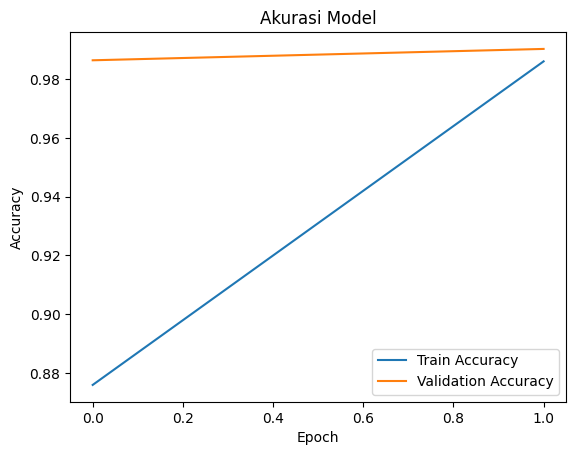

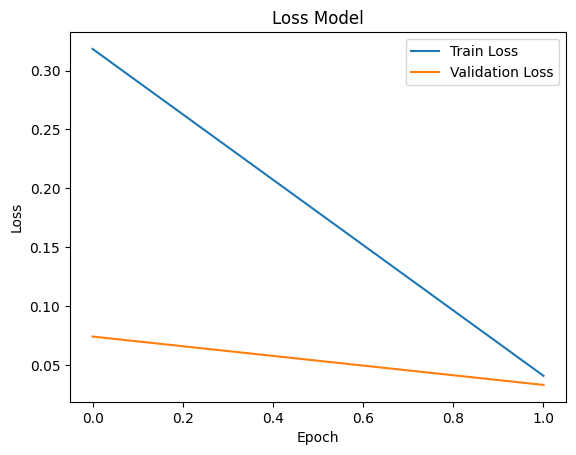

In [9]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step


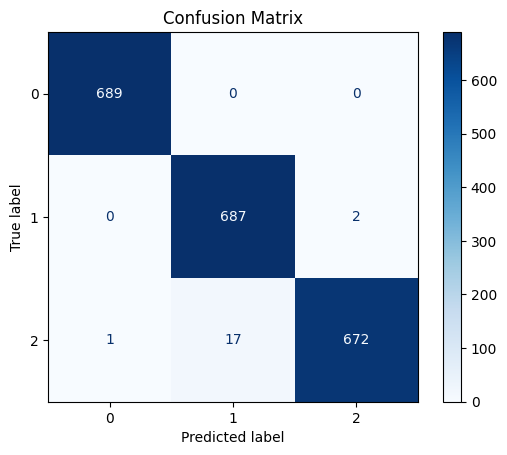

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       689
           1       0.98      1.00      0.99       689
           2       1.00      0.97      0.99       690

    accuracy                           0.99      2068
   macro avg       0.99      0.99      0.99      2068
weighted avg       0.99      0.99      0.99      2068



In [10]:

# Prediksi pada data uji
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # untuk multi-class softmax
y_true = y_test.argmax(axis=1)

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Optional: laporan klasifikasi
print(classification_report(y_true, y_pred_classes))
